In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import datetime
import numpy as np
import scipy
import pandas as pd
import torch
from torch import nn


In [3]:
import criscas
from criscas.utilities import create_directory, get_device, report_available_cuda_devices
from criscas.predict_model import *


In [4]:
base_dir = os.path.abspath('..')
base_dir

'/mnt/orisenbazuru/crispr'

### Read sample data

In [5]:
seq_df = pd.read_csv(os.path.join(base_dir, 'sample_data', 'abemax_sampledata.csv'), header=0)

In [6]:
seq_df

,ID,seq
0,CTRL_HEKsiteNO18,ACACACACACTTAGAATCTG
1,CTRL_RSF1NO2,ACCCATTAAAGTTGAGGTGA
2,CTRL_EMX1NO2,AGATTTATGCAAACGGGTTG
3,CTRL_FANCFNO3,AGCGGCGGCTGCACAACCAG
4,CTRL_FANCFNO5,AGGCCCGGCGCACGGTGGCG
5,CTRL_TARDBPNO2,CGGGAGTTCTTCTCTCAGTA
6,CTRL_HEKsiteNO1,GAACACAAAGCATAGACTGC
7,CTRL_HEKsiteNO9,GAAGACCAAGGATAGACTGC
8,CTRL_HEKsiteNO2,GAGTATGAGGCATAGACTGC
9,CTRL_EMX1NO1,GAGTCCGAGCAGAAGAAGAA


The models expect sequences (i.e. target sites) to be wrapped in a `pandas.DataFrame` with a header that includes `ID` of the sequence and `seq` columns.
The sequences should be of length 20 (i.e. 20 bases) and represent the protospacer target site.

In [7]:
# create a directory where we dump the predictions of the models
csv_dir = create_directory(os.path.join(base_dir, 'sample_data', 'predictions'))

### Specify device (i.e. CPU or GPU) to run the models on

Specify device to run the model on. The models can run on `GPU` or `CPU`. We can instantiate a device by running `get_device(to_gpu,gpu_index)` function. 

- To run on GPU we pass `to_gpu = True` and specify which card to use if we have multiple cards `gpu_index=int` (i.e. in case we have multiple GPU cards we specify the index counting from 0). 
- If there is no GPU installed, the function will return a `CPU` device.

We can get a detailed information on the GPU cards installed on the compute node by calling `report_available_cuda_devices` function.

In [ ]:
report_available_cuda_devices()

In [ ]:
# instantiate a device using the only one available :P
device = get_device(True, 0)
device

### Create a BE-DICT model by sepcifying the target base editor 

We start `BE-DICT` model by calling `BEDICT_CriscasModel(base_editor, device)` where we specify which base editor to use (i.e. `ABEmax`, `BE4`, `ABE8e`, `AID`) and the `device` we create earlier to run on.

In [10]:
base_editor = 'ABEmax'
bedict = BEDICT_CriscasModel(base_editor, device)

We generate predictions by calling `predict_from_dataframe(seq_df)` where we pass the data frame wrapping the target sequences. The function returns two objects:

- `pred_w_attn_runs_df` which is a data frame that contains predictions per target base and the attentions scores across all positions.

- `proc_df` which is a data frame that represents the processed sequence data frame we passed (i.e. `seq_df`)

In [11]:
pred_w_attn_runs_df, proc_df = bedict.predict_from_dataframe(seq_df)

--- processing input data frame ---
--- creating datatensor ---
--- building model ---
--- loading trained model ---
/mnt/orisenbazuru/crispr/trained_models/perbase/ABEmax/train_val/run_0
running prediction for base_editor: ABEmax | run_num: 0
--- loading trained model ---
/mnt/orisenbazuru/crispr/trained_models/perbase/ABEmax/train_val/run_1
running prediction for base_editor: ABEmax | run_num: 1
--- loading trained model ---
/mnt/orisenbazuru/crispr/trained_models/perbase/ABEmax/train_val/run_2
running prediction for base_editor: ABEmax | run_num: 2
--- loading trained model ---
/mnt/orisenbazuru/crispr/trained_models/perbase/ABEmax/train_val/run_3
running prediction for base_editor: ABEmax | run_num: 3
--- loading trained model ---
/mnt/orisenbazuru/crispr/trained_models/perbase/ABEmax/train_val/run_4
running prediction for base_editor: ABEmax | run_num: 4


`pred_w_attn_runs_df` contains predictions from 5 trained models for `ABEmax` base editor (we have 5 runs trained per base editor). For more info, see our [paper](https://www.biorxiv.org/content/10.1101/2020.07.05.186544v1) on biorxiv.

Target positions in the sequence reported in `base_pos` column in `pred_w_attn_runs_df` uses 0-based indexing (i.e. 0-19)

In [12]:
pred_w_attn_runs_df

,id,base_pos,prob_score_class0,prob_score_class1,Attn0,Attn1,Attn2,Attn3,Attn4,Attn5,...,Attn12,Attn13,Attn14,Attn15,Attn16,Attn17,Attn18,Attn19,run_id,model_name
0,CTRL_HEKsiteNO18,0,0.999415,0.000585,0.027925,0.086027,0.025536,0.105972,0.025897,0.097803,...,0.025387,0.055740,0.028766,0.026915,0.034891,0.074883,0.029865,0.050907,run_0,ABEmax
1,CTRL_HEKsiteNO18,2,0.977170,0.022830,0.040557,0.063859,0.046914,0.047787,0.043823,0.052100,...,0.042247,0.065526,0.032909,0.037879,0.047523,0.055335,0.047395,0.062291,run_0,ABEmax
2,CTRL_HEKsiteNO18,4,0.078551,0.921449,0.073174,0.012760,0.107905,0.005348,0.049966,0.007414,...,0.089955,0.025003,0.062065,0.084345,0.058772,0.011586,0.064722,0.026779,run_0,ABEmax
3,CTRL_HEKsiteNO18,6,0.244241,0.755759,0.071241,0.018726,0.066236,0.020042,0.053685,0.025337,...,0.073262,0.030468,0.075429,0.068449,0.058972,0.024722,0.067413,0.032715,run_0,ABEmax
4,CTRL_HEKsiteNO18,8,0.943315,0.056685,0.038176,0.047321,0.046204,0.040908,0.027377,0.036080,...,0.050011,0.072924,0.042522,0.053134,0.053315,0.055591,0.055033,0.068149,run_0,ABEmax
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,CTRL_NEK1NO2,11,0.758516,0.241484,0.043392,0.067804,0.055953,0.037912,0.031399,0.033730,...,0.060162,0.065220,0.037811,0.067300,0.067327,0.036905,0.062561,0.064595,run_4,ABEmax
601,CTRL_NEK1NO2,13,0.983103,0.016897,0.043239,0.076442,0.046463,0.023317,0.021245,0.024027,...,0.063422,0.091773,0.023187,0.092975,0.059049,0.023735,0.087398,0.089310,run_4,ABEmax
602,CTRL_NEK1NO2,15,0.999396,0.000604,0.025893,0.083139,0.033397,0.009446,0.007828,0.009213,...,0.063961,0.123827,0.008523,0.130358,0.055373,0.008935,0.125731,0.121970,run_4,ABEmax
603,CTRL_NEK1NO2,18,0.997911,0.002089,0.032907,0.079803,0.033759,0.012475,0.011501,0.013352,...,0.060229,0.118201,0.011760,0.122312,0.051734,0.012380,0.116946,0.117310,run_4,ABEmax


In [13]:
proc_df

,index,M1,M2,M3,M4,M5,M6,M7,M8,M9,...,B11,B12,B13,B14,B15,B16,B17,B18,B19,B20
0,0,1,0,1,0,1,0,1,0,1,...,2,2,0,3,0,0,2,1,2,3
1,1,1,0,0,0,1,0,0,1,1,...,3,2,2,3,0,3,3,2,3,0
2,2,1,0,1,0,0,0,1,0,0,...,0,0,0,1,3,3,3,2,2,3
3,3,1,0,0,0,0,0,0,0,0,...,3,1,0,1,0,0,1,1,0,3
4,4,1,0,0,0,0,0,0,0,0,...,1,0,1,3,3,2,3,3,1,3
5,5,0,0,0,0,1,0,0,0,0,...,2,1,2,1,2,1,0,3,2,0
6,6,0,1,1,0,1,0,1,1,1,...,1,0,2,0,3,0,1,2,3,1
7,7,0,1,1,0,1,0,0,1,1,...,3,0,2,0,3,0,1,2,3,1
8,8,0,1,0,0,1,0,0,1,0,...,1,0,2,0,3,0,1,2,3,1
9,9,0,1,0,0,0,0,0,1,0,...,0,3,0,0,3,0,0,3,0,0


Given that we have 5 predictions per sequence, we can further reduce to one prediction by either `averaging` across all models, or taking the `median` or `max` prediction based on the probability of editing scores. For this we use `select_prediction(pred_w_attn_runs_df, pred_option)` where `pred_w_attn_runs_df` is the data frame containing predictions from 5 models for each sequence. `pred_option` can be assume one of {`mean`, `median`, `max`}.

In [14]:
pred_option = 'mean'
pred_w_attn_df = bedict.select_prediction(pred_w_attn_runs_df, pred_option)

In [15]:
pred_w_attn_df

,id,base_pos,model_name,prob_score_class0,prob_score_class1,Attn0,Attn1,Attn2,Attn3,Attn4,...,Attn10,Attn11,Attn12,Attn13,Attn14,Attn15,Attn16,Attn17,Attn18,Attn19
0,CTRL_DOCK3NO2,1,ABEmax,0.995987,0.004013,0.052740,0.047744,0.055855,0.054183,0.047782,...,0.056627,0.045882,0.048618,0.055110,0.048572,0.046954,0.047141,0.059018,0.057540,0.043556
1,CTRL_DOCK3NO2,2,ABEmax,0.985492,0.014508,0.046498,0.055612,0.054520,0.053477,0.055922,...,0.048373,0.049114,0.051477,0.049339,0.047625,0.046630,0.045698,0.048829,0.058733,0.044709
2,CTRL_DOCK3NO2,4,ABEmax,0.049553,0.950447,0.044763,0.048347,0.062121,0.064239,0.051323,...,0.040425,0.040427,0.047703,0.024490,0.039254,0.042858,0.059218,0.028959,0.029523,0.076355
3,CTRL_DOCK3NO2,8,ABEmax,0.924553,0.075447,0.053932,0.045607,0.046519,0.051154,0.046231,...,0.048571,0.044802,0.044989,0.046060,0.044756,0.047376,0.053452,0.044826,0.044572,0.057940
4,CTRL_DOCK3NO2,9,ABEmax,0.973775,0.026225,0.048523,0.044746,0.045924,0.057421,0.048584,...,0.045673,0.043892,0.045718,0.056474,0.046544,0.050327,0.047164,0.052896,0.053611,0.046287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,HEKsite7LV,9,ABEmax,0.583722,0.416278,0.043865,0.048613,0.047245,0.051434,0.055011,...,0.043803,0.047368,0.047903,0.049892,0.047499,0.054591,0.043083,0.043406,0.043317,0.044964
117,HEKsite7LV,11,ABEmax,0.942926,0.057074,0.056344,0.051824,0.045288,0.054555,0.043363,...,0.065359,0.049152,0.050816,0.052743,0.047534,0.048580,0.054623,0.051120,0.051803,0.048568
118,HEKsite7LV,12,ABEmax,0.986732,0.013268,0.052283,0.071258,0.036059,0.057556,0.043354,...,0.057151,0.064720,0.054698,0.064043,0.053870,0.039717,0.049858,0.047170,0.049595,0.042083
119,HEKsite7LV,13,ABEmax,0.995614,0.004386,0.065106,0.054118,0.038792,0.050186,0.041060,...,0.071289,0.048702,0.055881,0.056559,0.054284,0.041243,0.057356,0.053311,0.054745,0.046273


We can dump the prediction results on a specified directory on disk. We will dump the predictions with all 5 runs `pred_w_attn_runs_df` and the one average across runs `pred_w_attn_df`.

Under `sample_data` directory we will have the following tree:

<code>
sample_data
└── predictions
    ├── predictions_allruns.csv
    └── predictions_predoption_mean.csv
</code>

In [16]:
pred_w_attn_runs_df.to_csv(os.path.join(csv_dir, f'predictions_allruns.csv'))

In [17]:
pred_w_attn_df.to_csv(os.path.join(csv_dir, f'predictions_predoption_{pred_option}.csv'))

### Generate attention plots

We can generate attention plots for the prediction of each target base in the sequence using `highlight_attn_per_seq` method that takes the following arguments:

- `pred_w_attn_runs_df`: data frame that contains model's predictions (5 runs) for each target base of each sequence (see above).
- `proc_df`: data frame that represents the processed sequence data frame we passed (i.e. seq_df)
- `seqid_pos_map`: dictionary `{seq_id:list of positions}` where `seq_id` is the ID of the target sequence, and list of positions that we want to generate attention plots for. Users can specify a `position from 1 to 20` (i.e. length of protospacer sequence)
- `pred_option`: selection option for aggregating across 5 models' predictions. That is we can average the predictions across 5 runs, or take `max`, `median`, `min` or `None` (i.e. keep all 5 runs) 
- `apply_attnscore_filter`: boolean (`True` or `False`) to further apply filtering on the generated attention scores. This filtering allow to plot only predictions where the associated attention scores have a maximum that is >= 3 times the base attention score value <=> (3 * 1/20)
- `fig_dir`: directory where to dump the generated plots or `None` (to return the plots inline)

seq_id: CTRL_HEKsiteNO1
highlighting seqid:CTRL_HEKsiteNO1, pos:4
seq_id: CTRL_HEKsiteNO2
highlighting seqid:CTRL_HEKsiteNO2, pos:4


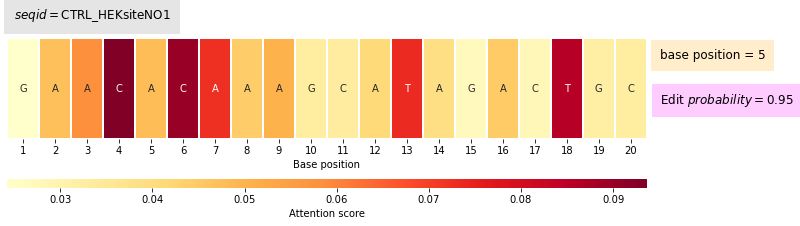

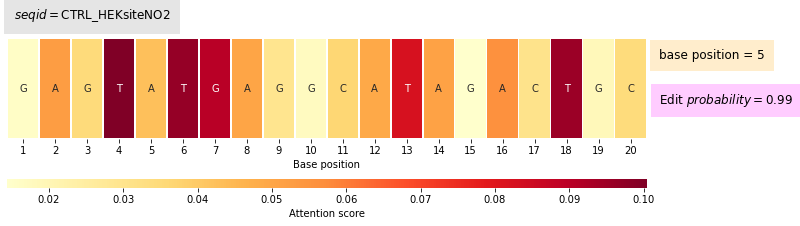

In [18]:
# create a dictionary to specify target sequence and the position we want attention plot for
# we are targeting position 5 in the sequence
seqid_pos_map = {'CTRL_HEKsiteNO1':[5], 'CTRL_HEKsiteNO2':[5]}
pred_option = 'mean'
apply_attn_filter = False
bedict.highlight_attn_per_seq(pred_w_attn_runs_df, 
                              proc_df,
                              seqid_pos_map=seqid_pos_map,
                              pred_option=pred_option, 
                              apply_attnscore_filter=apply_attn_filter, 
                              fig_dir=None)

We can save the plots on disk without returning them by specifing `fig_dir`

In [19]:
# create a dictionary to specify target sequence and the position I want attention plot for
# we are targeting position 5 in the sequence
seqid_pos_map = {'CTRL_HEKsiteNO1':[5], 'CTRL_HEKsiteNO2':[5]}
pred_option = 'mean'
apply_attn_filter = False
fig_dir =  create_directory(os.path.join(base_dir, 'sample_data', 'fig_dir'))
bedict.highlight_attn_per_seq(pred_w_attn_runs_df, 
                              proc_df,
                              seqid_pos_map=seqid_pos_map,
                              pred_option=pred_option, 
                              apply_attnscore_filter=apply_attn_filter, 
                              fig_dir=create_directory(os.path.join(fig_dir, pred_option)))

seq_id: CTRL_HEKsiteNO1
highlighting seqid:CTRL_HEKsiteNO1, pos:4
seq_id: CTRL_HEKsiteNO2
highlighting seqid:CTRL_HEKsiteNO2, pos:4


We will generate the following files:

<code>
sample_data
├── abemax_sampledata.csv
├── fig_dir
│   └── mean
│       ├── ABEmax_seqattn_CTRL_HEKsiteNO1_basepos_5_predoption_mean.pdf
│       └── ABEmax_seqattn_CTRL_HEKsiteNO2_basepos_5_predoption_mean.pdf
└── predictions
    ├── predictions_allruns.csv
    └── predictions_predoption_mean.csv
</code>

Similarly we can change the other arguments such as `pred_option` `apply_attnscore_filter` and so on to get different filtering options - We leave this as an exercise for the user/reader :D